# INDEX
* [Functions](#Functions)
* [Load datasets](#Load-datasets)
* [Configuration](#Configuration)
* [Preprocess training data](#Preprocess-training-data)
* [Train model](#Train-model)
* [Test model](#Test-model)
    * [Predict](#Predict)
    * [Translate predictions](#Translate-predictions)

# Prerequisites

* go to parent root folder of off-category-classification
* execute download.sh

# Functions

In [1]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [2]:
# %load libtrain.py
import datetime
import functools
import json
import pathlib
import shutil
import tempfile
from typing import Dict, List

import dacite
import pandas as pd
import tensorflow as tf
from robotoff.taxonomy import Taxonomy
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras import callbacks
from tensorflow.python.ops import summary_ops_v2

import settings
from category_classification.data_utils import (
    create_tf_dataset
)
from category_classification.models import (
    KerasPreprocessing,
    build_model,
    construct_preprocessing,
    to_serving_model,
)

from category_classification.config import Config

from utils.io import (
    copy_category_taxonomy,
    save_category_vocabulary,
    save_config,
    save_json,
)
from utils.metrics import evaluation_report

def create_model(config: Config, preprocess: KerasPreprocessing) -> keras.Model:
    model = build_model(config.model_config, preprocess)
    loss_fn = keras.losses.BinaryCrossentropy(
        label_smoothing=config.train_config.label_smoothing
    )
    optimizer = keras.optimizers.Adam(learning_rate=config.train_config.lr)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=["binary_accuracy", "Precision", "Recall"],
    )
    return model


class TBCallback(callbacks.TensorBoard):
    """Get around a bug where you cannot use the TensorBoard callback with the StringLookup layers
    - https://github.com/tensorflow/tensorboard/issues/4530#issuecomment-783318292"""

    def _log_weights(self, epoch):
        with self._train_writer.as_default():
            with summary_ops_v2.always_record_summaries():
                for layer in self.model.layers:
                    for weight in layer.weights:
                        if hasattr(weight, "name"):
                            weight_name = weight.name.replace(":", "_")
                            summary_ops_v2.histogram(weight_name, weight, step=epoch)
                            if self.write_images:
                                self._log_weight_as_image(weight, weight_name, epoch)
                self._train_writer.flush()


def train(
    model: keras.Model,
    save_dir: pathlib.Path,
    config: Config,
    category_vocab: List[str]
):
    print("Starting training...")
    temporary_log_dir = pathlib.Path(tempfile.mkdtemp())
    print("Temporary log directory: {}".format(temporary_log_dir))

    # for now, clear cache on each call to train(), to be safe
    cache_dir = pathlib.Path("tf_cache")
    shutil.rmtree(cache_dir, ignore_errors=True)
    cache_dir.mkdir()
    print("Cache directory: {}".format(cache_dir))

    train = (
        create_tf_dataset("train", category_vocab, config.train_config.batch_size)
        .cache(str(cache_dir / "train"))
    )
    val = (
        create_tf_dataset("val", category_vocab, config.train_config.batch_size)
        .cache(str(cache_dir / "val"))
    )


    history=model.fit(
        train,
        epochs= config.train_config.epochs,
        validation_data=val,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                filepath=str(save_dir / "weights.{epoch:02d}-{val_loss:.4f}"),
                monitor="val_loss",
                save_best_only=True,
                save_format='tf',
            ),
            #TBCallback(log_dir=str(temporary_log_dir), histogram_freq=1),
            callbacks.EarlyStopping(monitor="val_loss", patience=4),
            callbacks.CSVLogger(str(save_dir / "training.log")),
            callbacks.History()
        ],
    )
    print("Training ended")
    return history

# Load datasets

In [3]:
import pandas as pd
from robotoff.utils import gzip_jsonl_iter
import pathlib

import settings
from typing import Any, Callable, Dict, Iterable, Optional, List

def create_dataframe(split: str, lang: str) -> pd.DataFrame:
    if split not in ("train", "test", "val"):
        raise ValueError("split must be either 'train', 'test' or 'val'")

    file_name = "category_{}.{}.jsonl.gz".format(lang, split)
    full_path = settings.DATA_DIR / file_name
    return pd.DataFrame(iter_product(full_path))

def iter_product(data_path: pathlib.Path):
    for product in gzip_jsonl_iter(data_path):
        product.pop("images", None)

        if "nutriments" in product:
            nutriments = product["nutriments"] or {}

        yield product

In [4]:
training_ds = create_dataframe("train", "xx")
test_ds = create_dataframe("test", "xx")
val_ds = create_dataframe("val", "xx")

# Configuration

In [5]:
# load config json
import json
 
# Opening JSON file
with open('../config.json') as json_file:
    json_config = json.load(json_file)
json_config 

config=dacite.from_dict(Config, json_config)
model_config=config.model_config

output_dir:pathlib.Path = pathlib.Path("../models")
replicates = 1

output_dir.mkdir(parents=True, exist_ok=True)

# Preprocess training data

In [7]:
%%time
keras_preprocess = construct_preprocessing(
    model_config.category_min_count,
    model_config.ingredient_min_count,
    model_config.product_name_max_tokens,
    model_config.product_name_max_length,
    training_ds,
)
print("Pre-processed training data")

Pre-processed training data
CPU times: user 2.2 s, sys: 39.5 ms, total: 2.24 s
Wall time: 2.06 s


# Train model

In [8]:
%%time
import json

if replicates == 1:
    save_dirs = [output_dir]
else:
    save_dirs = [output_dir / str(i) for i in range(replicates)]

for i, save_dir in enumerate(save_dirs):
    model = create_model(config, keras_preprocess)
    save_dir.mkdir(exist_ok=True)
    config.train_config.start_datetime = str(datetime.datetime.utcnow())
    print(f"Starting training repeat {i}")

    save_config(config, save_dir)
    copy_category_taxonomy(settings.CATEGORY_TAXONOMY_PATH, save_dir)
    save_category_vocabulary(keras_preprocess.category_vocab, save_dir)
    # Get the dictionary containing each metric and the loss for each epoch
    history=train(
        model,
        save_dir,
        config,
        keras_preprocess.category_vocab,
    )

    config.train_config.end_datetime = str(datetime.datetime.utcnow())
    save_config(config, save_dir)
    config.train_config.start_datetime = None
    config.train_config.end_datetime = None

Starting training repeat 0
Starting training...
Temporary log directory: /tmp/tmplbjfe0f6
Cache directory: tf_cache


2022-04-19 20:29:11.318172: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/50
   5465/Unknown - 555s 101ms/step - loss: 0.0081 - binary_accuracy: 0.9985 - precision: 0.2406 - recall: 0.0965

2022-04-19 20:38:26.365969: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5465/5465 [==============================] - 581s 106ms/step - loss: 0.0081 - binary_accuracy: 0.9985 - precision: 0.2406 - recall: 0.0965 - val_loss: 0.0039 - val_binary_accuracy: 0.9990 - val_precision: 0.8566 - val_recall: 0.2743


2022-04-19 20:38:51.943791: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-04-19 20:38:53.605218: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/weights.01-0.0039/assets
Epoch 2/50
   2/5465 [..............................] - ETA: 5:54 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.8004 - recall: 0.3099

2022-04-19 20:38:56.651883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5465/5465 [==============================] - 420s 77ms/step - loss: 0.0032 - binary_accuracy: 0.9992 - precision: 0.8170 - recall: 0.4231 - val_loss: 0.0023 - val_binary_accuracy: 0.9994 - val_precision: 0.8846 - val_recall: 0.5564
INFO:tensorflow:Assets written to: ../models/weights.02-0.0023/assets
Epoch 3/50
5465/5465 [==============================] - 412s 75ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - precision: 0.8472 - recall: 0.5982 - val_loss: 0.0018 - val_binary_accuracy: 0.9995 - val_precision: 0.8854 - val_recall: 0.6749
INFO:tensorflow:Assets written to: ../models/weights.03-0.0018/assets
Epoch 4/50
5465/5465 [==============================] - 404s 74ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8588 - recall: 0.6674 - val_loss: 0.0016 - val_binary_accuracy: 0.9995 - val_precision: 0.8908 - val_recall: 0.7117
INFO:tensorflow:Assets written to: ../models/weights.04-0.0016/assets
Epoch 5/50
5465/5465 [==============================] - 404s 74ms/step -

In [9]:
log_data = pd.read_csv('../models/training.log', sep=',', engine='python')
log_data

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.998507,0.008054,0.240607,0.096496,0.999038,0.003913,0.856629,0.274321
1,1,0.999174,0.003237,0.817032,0.423091,0.999356,0.002264,0.884558,0.556374
2,2,0.999389,0.002223,0.847214,0.598250,0.999486,0.001766,0.885372,0.674948
3,3,0.999472,0.001857,0.858805,0.667424,0.999531,0.001599,0.890849,0.711706
4,4,0.999499,0.001684,0.865141,0.701060,0.999558,0.001512,0.888878,0.737102
5,5,0.999512,0.001574,0.869422,0.722408,0.999573,0.001466,0.891282,0.748443
6,6,0.999522,0.001494,0.872929,0.737751,0.999582,0.001434,0.889208,0.759799
7,7,0.999531,0.001433,0.875791,0.749582,0.999591,0.001415,0.890777,0.765475
8,8,0.999539,0.001388,0.877920,0.758054,0.999597,0.001398,0.889000,0.773217
9,9,0.999547,0.001348,0.879948,0.765666,0.999600,0.001392,0.889078,0.776664


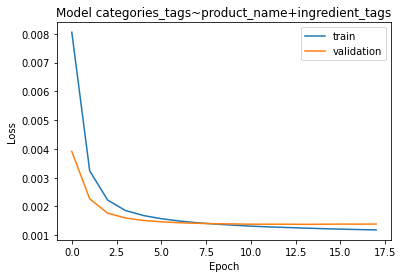

In [10]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

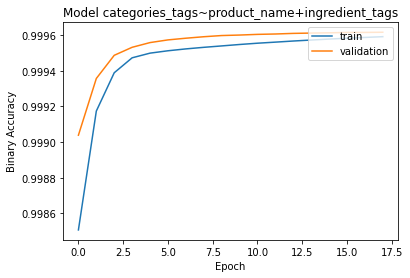

In [11]:
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['binary_accuracy'])
plt.plot(log_data['epoch'],log_data['val_binary_accuracy'])
plt.title('Model categories_tags~product_name+ingredient_tags')
plt.ylabel('Binary Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'validation'] , loc = 'upper right')
plt.show()

# Test model

In [10]:
# load saved model
model=keras.models.load_model('../models/base/saved_model')

In [11]:
# create train, validation, test datasets
category_vocab = keras_preprocess.category_vocab
batch_size = config.train_config.batch_size

# Train & validation Dataset => investigate on characteristics of the source
valdata = create_tf_dataset("val", category_vocab, batch_size)
testdata = create_tf_dataset("test", category_vocab, batch_size)

In [12]:
# categories count
len(category_vocab)

3969

## Predict

In [13]:
%%time
y_pred_val = model.predict(valdata)

CPU times: user 1min 33s, sys: 19.8 s, total: 1min 52s
Wall time: 1min 19s


In [14]:
%%time
y_pred_test=model.predict(testdata)

CPU times: user 1min 33s, sys: 17.2 s, total: 1min 50s
Wall time: 1min 19s


In [15]:
y_pred_val.shape, y_pred_test.shape

((87433, 3969), (87433, 3969))

In [16]:
y_pred_val

array([[1.2839634e-05, 2.3829339e-10, 1.6613468e-09, ..., 1.5564917e-11,
        3.6129602e-10, 2.1100532e-12],
       [1.0495579e-01, 2.0508166e-09, 2.3943665e-09, ..., 1.3911613e-08,
        1.0217517e-08, 3.8321792e-07],
       [1.9471225e-05, 6.9090309e-14, 3.4578873e-15, ..., 1.7461139e-10,
        1.5341870e-09, 3.1657670e-11],
       ...,
       [3.8076937e-03, 1.6157297e-06, 6.6229441e-06, ..., 1.5495658e-06,
        8.5407564e-06, 3.0552114e-06],
       [1.3194382e-03, 1.6692168e-10, 3.1451508e-09, ..., 4.1883496e-14,
        4.0008695e-17, 5.4479357e-14],
       [1.3995171e-04, 4.6972501e-09, 6.7628605e-07, ..., 2.1551737e-16,
        4.0634079e-10, 5.0259212e-15]], dtype=float32)

## Translate predictions

In [17]:
import numpy as np

data=y_pred_val
NUMBER_OF_CATEGORIES = 4

values=np.partition(data,-NUMBER_OF_CATEGORIES) #top n probability values for each row
indices=np.argpartition(data,-NUMBER_OF_CATEGORIES) #top n probability values indices for each row

In [18]:
val=values[:,-NUMBER_OF_CATEGORIES:] # filter n first values for each row
ind=indices[:,-NUMBER_OF_CATEGORIES:] # filter n first values indices for each row

In [19]:
dfPredictions=(pd.DataFrame(ind).applymap(lambda x:category_vocab[x])+": "+pd.DataFrame(np.round(val*100,2)).astype(str)+" %").reset_index()

In [20]:
# make dictionary from validation dataframe to get code ande product_name
dict_val=val_ds[['code','product_name']].to_dict()

In [21]:
dfPredictions['product_name']=dfPredictions['index'].apply(lambda x:dict_val['product_name'][x])
dfPredictions['code']=dfPredictions['index'].apply(lambda x:dict_val['code'][x])
dfPredictions=dfPredictions.drop(columns=["index"])

In [22]:
dfPredictions

,0,1,2,3,product_name,code
0,en:groceries: 96.52 %,en:salts: 98.63 %,en:fleurs-de-sel: 97.92 %,en:unrefined-salts: 97.0 %,Fleur de sel,3183280018259
1,en:cereals-and-potatoes: 65.28 %,en:breakfast-cereals: 71.68 %,en:plant-based-foods: 85.16 %,en:plant-based-foods-and-beverages: 85.63 %,coco pops,8690504270591
2,en:plant-based-foods-and-beverages: 74.35 %,en:plant-based-beverages: 75.87 %,en:hot-beverages: 87.98 %,en:beverages: 97.96 %,"Thé épicé Dreaming camomille, lavande & valériane",8719179003652
3,en:plant-milks: 78.42 %,en:milk-substitute: 80.89 %,en:soy-milks: 86.2 %,en:legume-milks: 86.33 %,Soja Vanille Drink,4316268502504
4,en:confectioneries: 59.83 %,en:snacks: 94.23 %,en:sweet-snacks: 94.86 %,en:nougats: 97.1 %,Nougat au miel de Bretagne,3770011407224
...,...,...,...,...,...,...
87428,en:fermented-milk-products: 95.78 %,en:yogurts: 96.79 %,en:dairies: 98.91 %,en:fermented-foods: 97.39 %,Milk chocolate,0072431253607
87429,en:poultries: 91.34 %,en:duck-breasts: 95.89 %,en:ducks: 95.94 %,en:meats: 97.83 %,Yaourt framboise,3175241413616
87430,fr:charcuteries-diverses: 11.99 %,en:prepared-meats: 78.72 %,en:meats: 80.52 %,en:cured-sausages: 29.25 %,Magret de canard,2685323047758
87431,en:cheeses: 99.26 %,en:fermented-milk-products: 99.66 %,en:fermented-foods: 99.69 %,en:dairies: 99.88 %,La fine douce et équilibrée,3700133913709
